In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
pwd

'/Users/sebas/projects/metabolomics/notebooks/ordinal_classification'

In [3]:
import os 
os.chdir('/Users/sebas/projects/metabolomics/')
# Set the environment variable
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [27]:
import dill
import torch
from torch.utils.data import DataLoader
from src.transformers.load_data_unique import LoadDataUnique
import lightning.pytorch as pl
from src.transformers.embedder import Embedder
from pytorch_lightning.callbacks import ProgressBar
from src.train_utils import TrainUtils
import matplotlib.pyplot as plt
from src.config import Config
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
import os
from src.parser import Parser
import random
from src.weight_sampling import WeightSampling
from src.losscallback import LossCallback
from src.molecular_pairs_set import MolecularPairsSet
from src.sanity_checks import SanityChecks
from src.transformers.postprocessing import Postprocessing
from scipy.stats import spearmanr

In [5]:
## Replicate standard regression training


In [6]:
## Train a classification model


In [7]:
## Use gumbel softmax function

## Replicate standard regression training

In [8]:
config = Config()

In [20]:
config.D_MODEL=128

In [9]:
data_folder= '/Users/sebas/projects/data/'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'

In [10]:
config.dataset_path=dataset_path
config.CHECKPOINT_DIR = data_folder + 'temp_training/'

In [11]:
# parameters
dataset_path = config.dataset_path
epochs = config.epochs
use_uniform_data = config.use_uniform_data_TRAINING
bins_uniformise = config.bins_uniformise_TRAINING
enable_progress_bar = config.enable_progress_bar
fig_path = config.CHECKPOINT_DIR + f"scatter_plot_{config.MODEL_CODE}.png"
model_code = config.MODEL_CODE

In [12]:
print("loading file")
# Load the dataset from the pickle file
with open(dataset_path, "rb") as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset["molecule_pairs_train"]
molecule_pairs_val = dataset["molecule_pairs_val"]
molecule_pairs_test = dataset["molecule_pairs_test"]
uniformed_molecule_pairs_test = dataset["uniformed_molecule_pairs_test"]

loading file


In [13]:

print(f"Number of pairs for train: {len(molecule_pairs_train)}")
print(f"Number of pairs for val: {len(molecule_pairs_val)}")
print(f"Number of pairs for test: {len(molecule_pairs_test)}")
print(f"Number of pairs for uniform test: {len(uniformed_molecule_pairs_test)}")

Number of pairs for train: 955957
Number of pairs for val: 586692
Number of pairs for test: 586781
Number of pairs for uniform test: 40940


In [14]:
## CALCULATION OF WEIGHTS
train_binned_list, _ = TrainUtils.divide_data_into_bins(
    molecule_pairs_train,
    config.bins_uniformise_TRAINING,
)
weights, range_weights = WeightSampling.compute_weights(train_binned_list)

In [15]:
weights_tr = WeightSampling.compute_sample_weights(molecule_pairs_train, weights)
weights_val = WeightSampling.compute_sample_weights(molecule_pairs_val, weights)

In [16]:
print("loading datasets")
if use_uniform_data:
    print("Uniformize the data")
    uniformed_molecule_pairs_train, train_binned_list = TrainUtils.uniformise(
        molecule_pairs_train, number_bins=bins_uniformise, return_binned_list=True
    )
    uniformed_molecule_pairs_val, _ = TrainUtils.uniformise(
        molecule_pairs_val, number_bins=bins_uniformise, return_binned_list=True
    )
    # uniformed_molecule_pairs_test,_ =TrainUtils.uniformise(molecule_pairs_test, number_bins=bins_uniformise, return_binned_list=True)
    m_train = uniformed_molecule_pairs_train
    # m_test= uniformed_molecule_pairs_test
    m_val = uniformed_molecule_pairs_val
else:
    m_train = molecule_pairs_train
    # m_test= molecule_pairs_test
    m_val = molecule_pairs_val

loading datasets


In [17]:
dataset_train = LoadDataUnique.from_molecule_pairs_to_dataset(m_train, training=True)
# dataset_test = LoadData.from_molecule_pairs_to_dataset(m_test)
dataset_val = LoadDataUnique.from_molecule_pairs_to_dataset(m_val)

Preprocessing all the data ...


261349it [00:06, 37676.49it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...


31318it [00:00, 47060.62it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [18]:
# delete variables that are not useful for memory savings
del molecule_pairs_train
del molecule_pairs_val
del molecule_pairs_test
del uniformed_molecule_pairs_test
del m_train
del m_val

In [19]:
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """WeightedRandomSampler except allows for more than 2^24 samples to be sampled"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(
            range(0, len(self.weights)),
            size=self.num_samples,
            p=self.weights.numpy() / torch.sum(self.weights).numpy(),
            replace=self.replacement,
        )
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())


train_sampler = CustomWeightedRandomSampler(
    weights=weights_tr, num_samples=len(dataset_train), replacement=True
)
val_sampler = CustomWeightedRandomSampler(
    weights=weights_val, num_samples=len(dataset_val), replacement=True
)

In [20]:
print("Creating train data loader")
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE, sampler=train_sampler, num_workers=10
)

Creating train data loader


In [21]:
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)


print("Creating val data loader")
dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    sampler=val_sampler,
    worker_init_fn=worker_init_fn,
    num_workers=0,
)


Creating val data loader


In [22]:
# Define the ModelCheckpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

checkpoint_n_steps_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model_n_steps",
    every_n_train_steps=100000,
    save_last=True,
    save_top_k=1,
)


# checkpoint_callback = SaveBestModelCallback(file_path=config.best_model_path)
progress_bar_callback = ProgressBar()

# loss callback
losscallback = LossCallback(file_path=config.CHECKPOINT_DIR + f"loss.png")
print("define model")


define model


In [23]:
model = Embedder(
    d_model=int(config.D_MODEL),
    n_layers=int(config.N_LAYERS),
    weights=None,
    lr=config.LR,
    use_cosine_distance=config.use_cosine_distance,
)

Using cosine library from Pytorch?: True


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type                             | Params
-----------------------------------------------------------------------------
0 | linear                  | Linear                           | 262 K 
1 | linear_regression       | Linear                           | 513   
2 | fixed_linear_regression | FixedLinearRegression            | 513   
3 | relu                    | ReLU                             | 0     
4 | spectrum_encoder        | SpectrumTransformerEncoderCustom | 11.0 M
5 | regression_loss         | MSELoss                          | 0     
6 | dropout                 | Dropout                          | 0     
7 | linear_cosine           | Linear                           | 262 K 
8 | cosine_similarity       | CosineSimilarity                 | 0     
--------------------------------------------------

Sanity Checking: |                                                                                            …

Train loss:
[]
Validation loss
[0.41819602251052856, 0.4386153221130371]


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


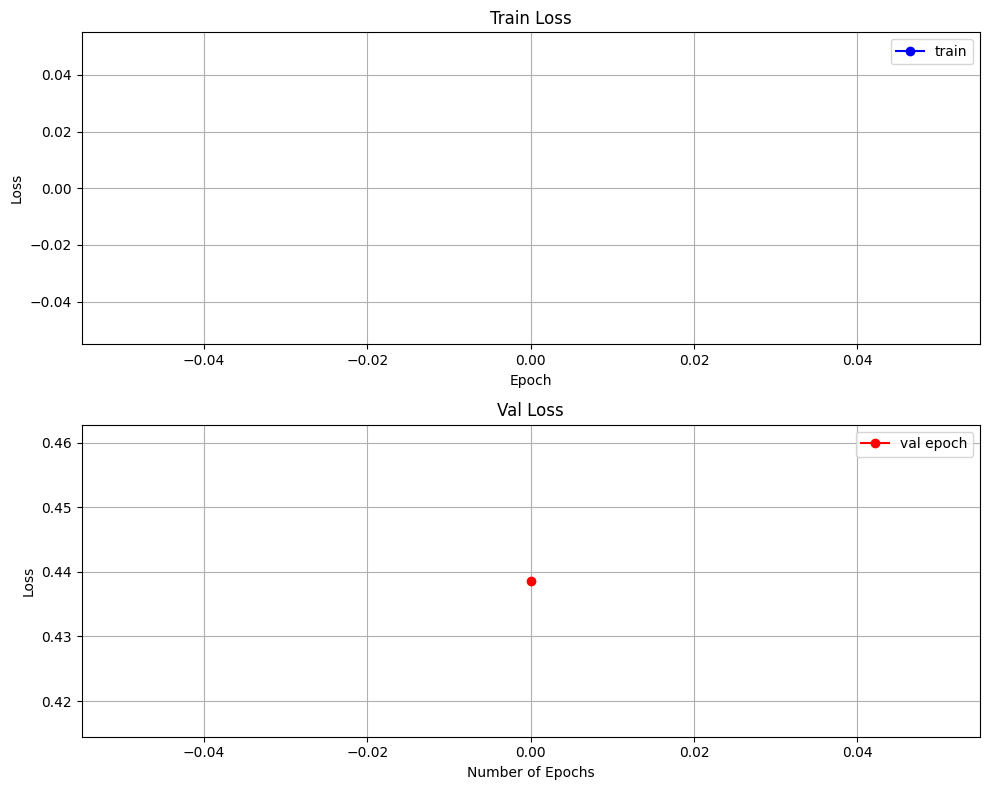

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    self._run_once()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/asyncio/base_events.py", line 1884,

In [25]:
trainer = pl.Trainer(
    max_epochs=epochs,
    callbacks=[checkpoint_callback, checkpoint_n_steps_callback, losscallback],
    enable_progress_bar=enable_progress_bar,
    # val_check_interval= config.validate_after_ratio,
)
# trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)

## Inference

In [14]:
molecule_pairs_test = dataset["molecule_pairs_test"]
print(f"Number of molecule pairs: {len(molecule_pairs_test)}")
print("Uniformize the data")
uniformed_molecule_pairs_test, _ = TrainUtils.uniformise(
    molecule_pairs_test,
    number_bins=bins_uniformise,
    return_binned_list=True,
    bin_sim_1=False,
)  # do not treat sim==1 as another bin

Number of molecule pairs: 586781
Uniformize the data


In [15]:
uniformed_molecule_pairs_test, _ = TrainUtils.uniformise(
    molecule_pairs_test,
    number_bins=bins_uniformise,
    return_binned_list=True,
    bin_sim_1=False,
)  # do not treat sim==1 as another bin


In [17]:
# dataset_train = LoadData.from_molecule_pairs_to_dataset(m_train)
dataset_test = LoadDataUnique.from_molecule_pairs_to_dataset(uniformed_molecule_pairs_test)
dataloader_test = DataLoader(dataset_test, batch_size=config.BATCH_SIZE, shuffle=False)

Preprocessing all the data ...


33719it [00:02, 11334.66it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [18]:
best_model_path = model_path = data_folder + 'best_model_exhaustive_sampled_128n_20240618.ckpt'
#best_model_path = self.CHECKPOINT_DIR + f"best_model.ckpt"

In [21]:
# Testinbest_model = Embedder.load_from_checkpoint(checkpoint_callback.best_model_path, d_model=64, n_layers=2)
trainer = pl.Trainer(max_epochs=2, enable_progress_bar=enable_progress_bar)
best_model = Embedder.load_from_checkpoint(
    best_model_path,
    d_model=int(config.D_MODEL),
    n_layers=int(config.N_LAYERS),
    use_element_wise=True,
    use_cosine_distance=config.use_cosine_distance,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


In [24]:
pred_test = trainer.predict(
    best_model,
    dataloader_test,
)
similarities_test = Postprocessing.get_similarities(dataloader_test)


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = torch.tensor(kwargs["precursor_charge"].float())


In [25]:
# flat the results
flat_pred_test = []
for pred in pred_test:
    flat_pred_test = flat_pred_test + [float(p) for p in pred]
combinations_test = [(s, p) for s, p in zip(similarities_test, flat_pred_test)]

new_combinations_test = []

In [28]:
# clip the values
x = np.array([c[0] for c in combinations_test])
y = np.array([c[1] for c in combinations_test])
y = np.clip(y, 0, 1)

corr_model, p_value_model= spearmanr(x, y)


In [1]:
# plot scatter
plt.xlabel("tanimoto similarity")
plt.ylabel("prediction similarity")
plt.scatter(x, y, label="test", alpha=0.01)
# plt.scatter(similarities_test,cosine_similarity_test, label='test')
plt.title(f'Spearman Correlation: {corr_model}')
plt.legend()
plt.grid()

NameError: name 'plt' is not defined

In [ ]:
print(f"Number of test samples: {len(y)}")
sns.set_theme(style="ticks")
plot = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391", joint_kws=dict(alpha=1))
# Set x and y labels
plot.set_axis_labels("Tanimoto similarity", "Model prediction", fontsize=12)